In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr
import scipy.optimize

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

In [2]:
import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr

In [3]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=4)

In [4]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.247:39103 Dashboard: http://10.148.0.247:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load data

In [6]:
root_path = '/home/datawork-lops-osi/equinox/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp4_m1a1_4km_500a1000j/'

In [7]:
runs = [file for file in os.listdir(root_path) if file.endswith('m1a1_4km_500a1000j')]#+'*5000a1000j/')]

In [30]:

def read_ds(run,V,dti,dij):
    gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
    r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
    r['surf'] = r['surf'].rename({'time_instant': 'time'})
    ds_a = (r['his'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                             'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                             'time': slice(0,None,dti)})
         ).squeeze()
    for v in ['u','v']:
        ds_a[v+'_a'] = x2rho(ds_a[v+'_a'],r.xgrid,'extrapolate')
    ds_a['u_mean'] = ds_a.u_a.mean('time')
    ds_a['v_mean'] = ds_a.v_a.mean('time')
    ds_a['u_prime'] = ds_a['u_a']-ds_a['u_mean']
    ds_a['v_prime'] = ds_a['v_a']-ds_a['v_mean']
    ds_a['EKE'] = ds_a['u_prime']**2+ds_a['v_prime']**2
    ds_a = ds_a.persist()
    return ds_a

In [28]:
runs

['jet_cfg1_wp4_m1a1_4km_500a1000j',
 'jet_cfg1_wp5_m1a1_4km_500a1000j',
 'jet_cfg1_wp6_m1a1_4km_500a1000j',
 'jet_cfg1_wp7_m1a1_4km_500a1000j',
 'jet_cfg1_wp8_m1a1_4km_500a1000j']

In [31]:
V = ['u_a', 'v_a']#,'ssh'
dij = 1
dti = 1
ds = [read_ds(Run, V,dti,dij) for Run in runs]

In [35]:
from matplotlib.lines import Line2D
number = len(ds)
cmap = plt.get_cmap('YlOrBr')
colors = [cmap(i) for i in np.linspace(0.3, 1, number)]
#custom_lines = [
#                Line2D([0], [0], color=cmap(.6), lw=1)
#               ]
custom_lines,labels = [],[]

<ipython-input-45-5e57fe2ca73e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks*1e-3);


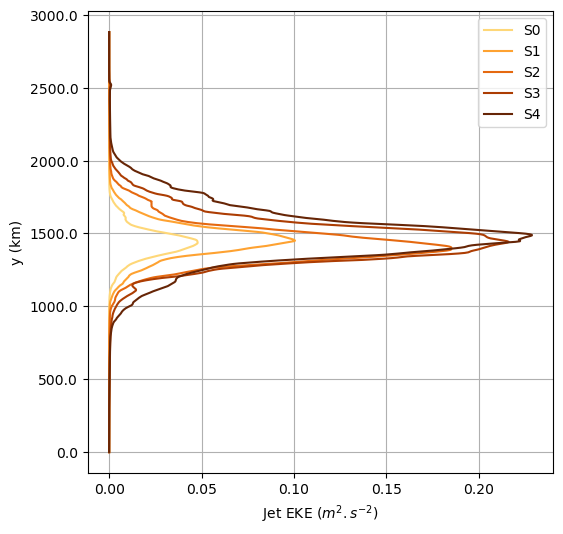

In [45]:
fig,ax = plt.subplots(figsize=(6,6))
for i,d in enumerate(ds):
    d.EKE.isel(s_rho=-1).mean(['time','x_rho']).plot(y='y_rho',c=colors[i])
    custom_lines.append(Line2D([0], [0], color=colors[i], lw=3))
    labels.append('S%s'% i)
ax.set_ylabel('y (km)');ax.set_xlabel(r'Jet EKE ($m^2.s^{-2}$)') 
ax.grid();ax.set_title('')
ax.legend(labels)
ticks = ax.get_yticks()
ax.set_yticklabels(ticks*1e-3);
plt.show()


In [13]:
from collections import OrderedDict

def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [46]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
